In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk

nltk.download('stopwords', quiet=True)
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

In [2]:
# Load the datasets
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape :", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape : (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [3]:
# Train-validation split
X = train_df["Review Comment"]
y = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [4]:
# ----- Pipeline with Decision Tree -----
base_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=2
    )),
    ("clf", DecisionTreeClassifier(
        random_state=SEED,
        splitter="best"
    ))
])

In [5]:
param_grid = {
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [None, 10, 25, 50],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)
search.fit(X_train, y_train)

print("Best CV-accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_pipeline = search.best_estimator_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best CV-accuracy: 0.5316581123467351
Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2)}


In [6]:
final_model = best_pipeline if 'best_pipeline' in globals() else base_pipeline
final_model.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 DecisionTreeClassifier(min_samples_split=5, random_state=42))])

In [7]:
# ----- Evaluation on test set -----
X_test  = test_df["Review Comment"]
y_test  = test_df["Expected Operation by Developer"]

y_pred  = final_model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

Test accuracy: 0.5769

Classification report:
               precision    recall  f1-score   support

      delete       0.52      0.60      0.56        78
      insert       0.59      0.59      0.59        81
     replace       0.65      0.53      0.58        75

    accuracy                           0.58       234
   macro avg       0.58      0.58      0.58       234
weighted avg       0.58      0.58      0.58       234



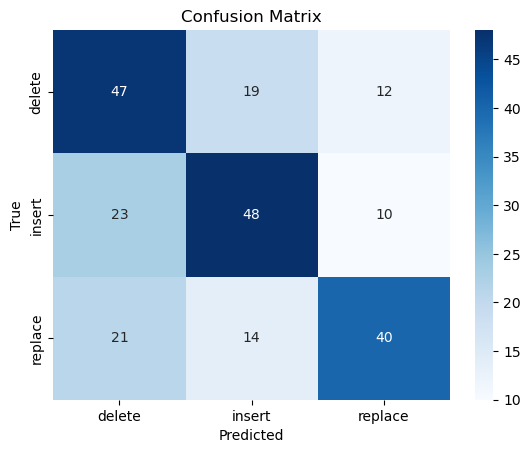

In [8]:
# Confusion matrix heat-map
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [9]:
# ----- Show top informative terms -----
def show_top_weights(model, n=15):
    clf   = model.named_steps["clf"]
    tfidf = model.named_steps["tfidf"]
    feature_names = np.array(tfidf.get_feature_names_out())

    importances = clf.feature_importances_
    top = np.argsort(importances)[-n:]
    print("\nTop informative terms:")
    print(", ".join(feature_names[top]))

show_top_weights(final_model, n=15)



Top informative terms:
maybe, coreboot, long, removed, extra, like, don, need, space, instead, just, needed, use, add, remove
